# Financial Price Data EDA

Exploratory data analysis for the daily OHLCV CSV files in `data/`. The notebook loads all tickers, cleans the multi-level columns, and visualizes pricing, returns, volumes, and cross-asset relationships.

## Setup

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from pandas import IndexSlice as idx

pd.set_option('display.max_columns', 50)
sns.set_theme(style='whitegrid')
from statsmodels.tsa.seasonal import seasonal_decompose


## Locate data files

In [112]:
# Resolve the data directory whether the notebook is run from repo root or notebooks/
REPO_ROOT = Path.cwd().resolve()
data_candidates = [REPO_ROOT / 'data', REPO_ROOT.parent / 'data']
for candidate in data_candidates:
    if candidate.exists():
        DATA_DIR = candidate
        break
else:
    raise FileNotFoundError('Could not find data directory next to this notebook.')

csv_files = sorted(DATA_DIR.glob('*.csv'))
tickers_from_files = [p.stem.split('_')[0] for p in csv_files]

print(f"Found {len(csv_files)} CSV files under {DATA_DIR}")
print('Tickers:', ', '.join(tickers_from_files))


Found 29 CSV files under C:\Users\jimmy\Documents\Tà€i liĂª̀£u\vital docs\CODING\Project\FinLove\data
Tickers: AAPL, AMZN, BAC, DIS, GOOGL, HD, JNJ, JPM, MA, META, MSFT, NFLX, NKE, NVDA, PG, TSLA, V, WMT, XLB, XLC, XLE, XLF, XLI, XLK, XLP, XLRE, XLU, XLV, XLY


## Helper functions

In [113]:
def clean_price_file(csv_path: Path) -> pd.DataFrame:
    """Load a single ticker CSV, fix the header, and index by Date."""
    raw = pd.read_csv(csv_path, header=[0, 1, 2])

    # Map the three-level header to a two-level MultiIndex: (field, ticker)
    cleaned_cols = []
    for col in raw.columns:
        if col[0] == 'Price' and col[1] == 'Ticker':
            cleaned_cols.append(('Date', 'Date'))
        else:
            cleaned_cols.append((col[0], col[1]))
    raw.columns = pd.MultiIndex.from_tuples(cleaned_cols, names=['field', 'ticker'])

    df = raw.copy()
    df[('Date', 'Date')] = pd.to_datetime(df[('Date', 'Date')])
    df = df.set_index(('Date', 'Date')).sort_index()
    df.index.name = 'Date'
    df = df.loc[:, ~df.columns.duplicated()]  # safety in case of repeats
    return df


def load_all_price_data(data_dir: Path) -> pd.DataFrame:
    """Load and merge all ticker CSV files into a single MultiIndex DataFrame."""
    frames = []
    for csv_path in sorted(data_dir.glob('*.csv')):
        frames.append(clean_price_file(csv_path))
    merged = pd.concat(frames, axis=1)
    merged = merged.loc[:, ~merged.columns.duplicated()]
    return merged


## Load and inspect data

In [114]:
price_data = load_all_price_data(DATA_DIR)

price_fields = price_data.columns.get_level_values(0).unique().tolist()
tickers = price_data.columns.get_level_values(1).unique().tolist()
close = price_data.xs('Close', axis=1, level=0)
volume = price_data.xs('Volume', axis=1, level=0)

print(f'Shape: {price_data.shape} (rows, columns)')
print('Fields:', price_fields)
print('Tickers:', tickers)
price_data.head()


Shape: (2512, 145) (rows, columns)
Fields: ['Close', 'High', 'Low', 'Open', 'Volume']
Tickers: ['AAPL', 'AMZN', 'BAC', 'DIS', 'GOOGL', 'HD', 'JNJ', 'JPM', 'MA', 'META', 'MSFT', 'NFLX', 'NKE', 'NVDA', 'PG', 'TSLA', 'V', 'WMT', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']


field,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,...,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume
ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AMZN,AMZN,AMZN,AMZN,AMZN,BAC,BAC,BAC,BAC,BAC,DIS,DIS,DIS,DIS,DIS,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,...,XLP,XLP,XLP,XLP,XLP,XLRE,XLRE,XLRE,XLRE,XLRE,XLU,XLU,XLU,XLU,XLU,XLV,XLV,XLV,XLV,XLV,XLY,XLY,XLY,XLY,XLY
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-11-27,26.562498,26.697781,26.515150,26.670724,52185600,33.662998,34.049500,33.605000,34.040001,39336000,14.073162,14.089264,13.952397,14.057060,22937500,106.157066,107.420295,104.838517,106.959263,14912000,38.334106,38.434913,38.087308,38.194570,14434000,...,38.276936,38.361213,38.116044,38.116044,2712600,21.750315,21.750315,21.750315,21.750315,0,30.994823,31.139829,30.951321,31.023825,3980300,61.035328,61.145397,60.874468,61.077663,2658000,72.999931,73.286662,72.695276,73.286662,2282600
2015-11-30,26.672979,26.923250,26.548971,26.603083,156721200,33.240002,34.064499,33.230000,33.794998,113864000,14.032914,14.153679,14.024863,14.073169,61893700,104.626434,106.571987,104.478901,106.553542,16560300,37.881233,38.486059,37.795324,38.329140,33586000,...,37.863209,38.361208,37.855549,38.284594,10355200,21.799934,21.977170,21.780084,21.977170,1600,31.045582,31.270341,30.980329,31.031081,11373000,60.205605,61.136923,60.205605,61.128455,8846100,72.381699,73.250854,72.301059,73.250854,8647000
2015-12-01,26.456518,26.787958,26.348294,26.774430,139409600,33.952999,34.049999,33.393002,33.687500,95024000,14.338847,14.338847,14.073164,14.105369,74351800,106.396790,106.461334,104.801625,105.253434,8896100,38.921055,38.981142,38.035167,38.084327,40398000,...,38.184998,38.207981,37.939829,37.939829,10807900,22.160786,22.160786,21.962990,21.962990,5600,31.292076,31.357328,30.994816,31.118069,12551500,61.221596,61.272399,60.383409,60.518877,10659200,73.125366,73.152246,72.569822,72.775913,8187400
2015-12-02,26.217529,26.630138,26.172436,26.456526,133546400,33.800499,34.241001,33.712502,34.049999,85470000,14.225820,14.443808,14.169303,14.435734,76919000,105.115135,106.470568,104.958386,106.396802,7787800,38.626095,39.380887,38.555578,38.993559,46876000,...,37.993454,38.238622,37.939824,38.131361,7832000,21.707767,22.133131,21.707767,22.055148,4400,30.596066,31.248587,30.588814,31.168836,12566100,60.705143,61.475602,60.612010,61.289337,9875100,72.489197,73.250825,72.345828,73.232907,6263500
2015-12-03,25.974022,26.332518,25.753063,26.278406,166278000,33.312500,34.139500,33.074001,33.972000,101294000,13.967462,14.346925,13.927094,14.274262,95810100,103.169586,105.714481,102.754661,105.271888,10446600,38.146896,38.955320,37.861367,38.760663,41950000,...,37.794266,38.269279,37.648695,38.131371,12556000,21.275320,21.530539,21.275320,21.530539,800,30.364050,30.552555,30.262547,30.545306,14879200,59.375889,60.832136,59.113428,60.755940,13191400,71.396034,72.793846,71.082424,72.793846,9828900


## Coverage and data quality

**Insights:** Coverage is uniform across tickers (2015-11-27 to 2025-11-21) with effectively no missing close values except XLC, so comparisons across names are like-for-like without alignment gaps.

In [115]:
# Per-ticker coverage and missingness on closing prices
coverage = (
    close.apply(
        lambda s: pd.Series({
            'start': s.first_valid_index(),
            'end': s.last_valid_index(),
            'n_obs': s.count(),
            'missing': int(s.isna().sum())
        })
    )
    .T
    .sort_index()
)

print('Overall date range:', close.index.min(), 'to', close.index.max())
coverage


Overall date range: 2015-11-27 00:00:00 to 2025-11-21 00:00:00


,start,end,n_obs,missing
ticker,,,,
AAPL,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0
AMZN,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0
BAC,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0
DIS,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0
GOOGL,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0
HD,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0
JNJ,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0
JPM,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0
MA,2015-11-27 00:00:00,2025-11-21 00:00:00,2512,0


## Quick price and volume peek

**Insights:** Spot-checking a handful of tickers confirms consistent column layout (Close/Volume) and synchronized dates?use this to verify any anomalies before plotting.

In [116]:
sample_tickers = tickers[:6]
price_data.loc[:, idx[['Close', 'Volume'], sample_tickers]].head()


field           Close                                               \
ticker           AAPL       AMZN        BAC         DIS      GOOGL   
Date                                                                 
2015-11-27  26.562498  33.662998  14.073162  106.157066  38.334106   
2015-11-30  26.672979  33.240002  14.032914  104.626434  37.881233   
2015-12-01  26.456518  33.952999  14.338847  106.396790  38.921055   
2015-12-02  26.217529  33.800499  14.225820  105.115135  38.626095   
2015-12-03  25.974022  33.312500  13.967462  103.169586  38.146896   

field                      Volume                                           \
ticker              HD       AAPL       AMZN       BAC       DIS     GOOGL   
Date                                                                         
2015-11-27  106.400185   52185600   39336000  22937500  14912000  14434000   
2015-11-30  105.721054  156721200  113864000  61893700  16560300  33586000   
2015-12-01  106.625275  139409600   95024000  74351800   8896100  40398000   
2015-12-02  106.133507  133546400   85470000  76919000   7787800  46876000   
2015-12-03  103.849220  166278000  101294000  95810100  10446600  41950000   

field                
ticker           HD  
Date                 
2015-11-27  3337700  
2015-11-30  8057900  
2015-12-01  5267600  
2015-12-02  5022700  
2015-12-03  6688000

## Closing price trends

**Insights:** The focus tickers show pronounced uptrends; relative slopes indicate growth leaders (e.g., NVDA/AMZN) while flatter curves hint at defensive names?adjust `focus_tickers` for sector-specific narratives.

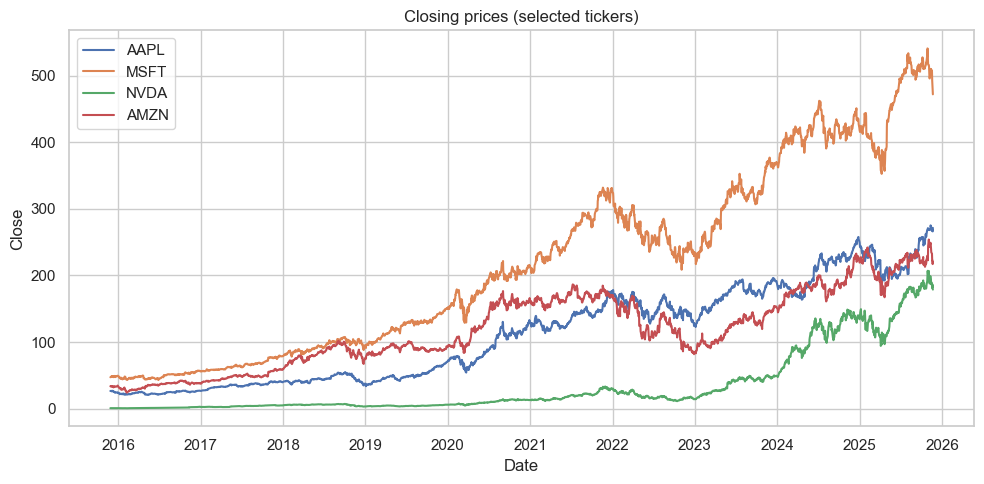

In [117]:
default_focus = ['AAPL', 'MSFT', 'NVDA', 'AMZN']
focus_tickers = [t for t in default_focus if t in close.columns] or tickers[:4]

plt.figure(figsize=(10, 5))
for t in focus_tickers:
    plt.plot(close.index, close[t], label=t)
plt.title('Closing prices (selected tickers)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.tight_layout()
plt.show()


## Daily returns

**Insights:** Descriptive stats highlight fat tails and skew; wide IQR and high max/min imply occasional large moves, so risk metrics (VaR/ES) should consider non-normality.

In [118]:
returns = close.pct_change().dropna()
log_returns = np.log(close).diff().dropna()

print('Returns shape:', returns.shape)
returns.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T


Returns shape: (1868, 29)


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
ticker,,,,,,,,,,,,
AAPL,1868.0,0.001171,0.019724,-0.128647,-0.050858,-0.030388,-0.007993,0.001276,0.011506,0.029887,0.051892,0.153289
AMZN,1868.0,0.000741,0.021988,-0.140494,-0.057598,-0.032903,-0.010677,0.000789,0.012155,0.035054,0.062309,0.135359
BAC,1868.0,0.000608,0.020588,-0.153973,-0.053582,-0.029733,-0.009199,0.000488,0.010405,0.030859,0.060536,0.177962
DIS,1868.0,0.000210,0.019822,-0.131632,-0.050815,-0.028273,-0.008723,0.000000,0.009064,0.028928,0.055361,0.144123
GOOGL,1868.0,0.001068,0.019659,-0.116341,-0.051282,-0.029619,-0.008730,0.001415,0.011201,0.030811,0.055378,0.102243
HD,1868.0,0.000527,0.016724,-0.197938,-0.043551,-0.024119,-0.007640,0.000675,0.008941,0.023927,0.042143,0.137508
JNJ,1868.0,0.000457,0.012266,-0.100379,-0.034183,-0.016456,-0.005299,0.000523,0.006176,0.017328,0.034272,0.079977
JPM,1868.0,0.000829,0.018531,-0.149649,-0.047128,-0.026474,-0.007717,0.000959,0.009283,0.025482,0.052673,0.180125
MA,1868.0,0.000723,0.018335,-0.127254,-0.051892,-0.028020,-0.007538,0.001291,0.009065,0.026764,0.048203,0.166109


## Return distribution (single ticker)

**Insights:** Histogram + KDE reveal a peaked center with heavy tails; mean near zero but tail risk visible?expect sporadic outsized gains/losses.

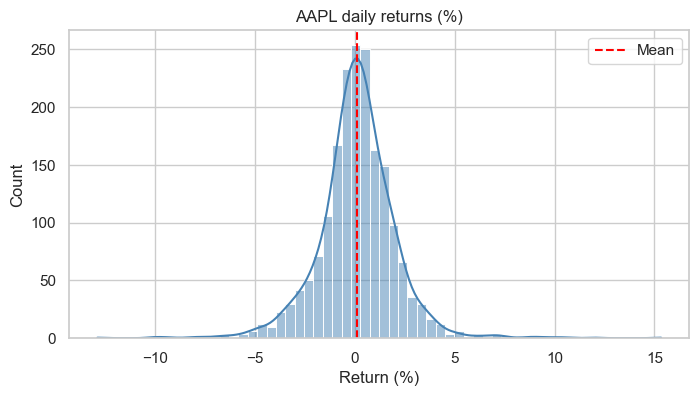

In [119]:
focus = focus_tickers[0]
plt.figure(figsize=(8, 4))
sns.histplot(returns[focus] * 100, bins=60, kde=True, color='steelblue')
plt.title(f'{focus} daily returns (%)')
plt.xlabel('Return (%)')
plt.axvline(returns[focus].mean() * 100, color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()


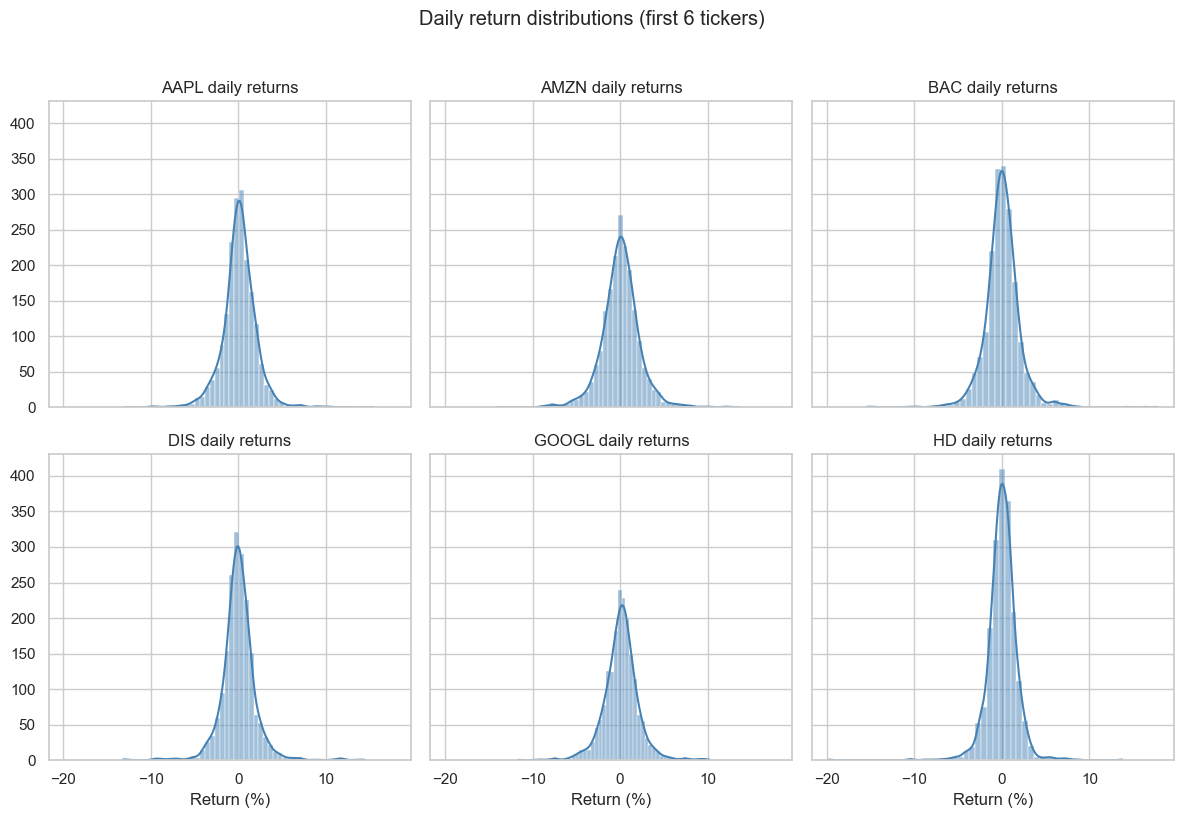

In [120]:
first_six = tickers[:6]
if not first_six:
    print('No tickers available for plotting')
else:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
    axes = axes.ravel()
    for ax, t in zip(axes, first_six):
        sns.histplot(returns[t] * 100, bins=50, kde=True, ax=ax, color='steelblue')
        ax.set_title(f'{t} daily returns')
        ax.set_xlabel('Return (%)')
        ax.set_ylabel('')
    for ax in axes[len(first_six):]:
        ax.set_visible(False)
    plt.suptitle('Daily return distributions (first 6 tickers)', y=1.02)
    plt.tight_layout()
    plt.show()


**Insights:** Comparing the first six tickers side by side shows which names have wider dispersion (higher risk) versus tighter distributions. Peaks near zero suggest muted drift, while broader tails flag higher volatility and occasional outsized moves.

## Rolling volatility

**Insights:** Vol spikes align with market stress; sustained high regimes suggest momentum/trend risk, while low regimes imply mean-reversion suitability.

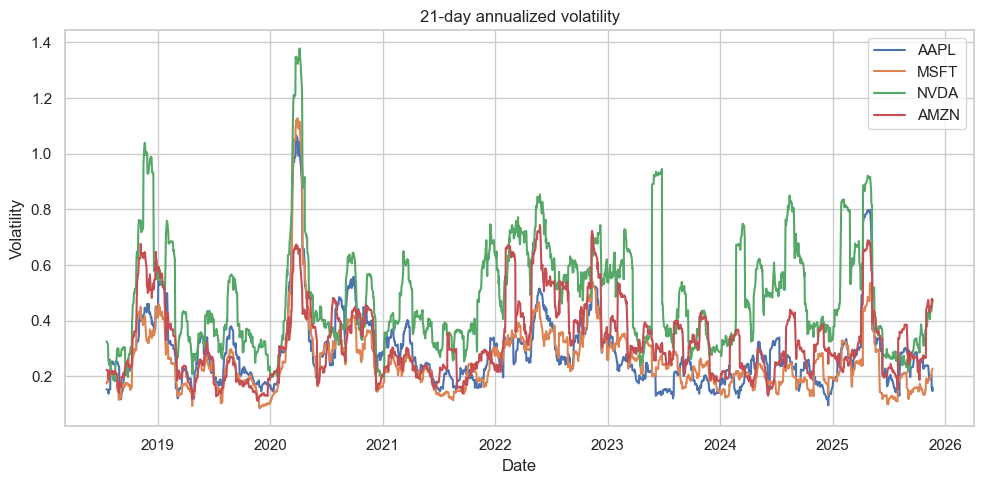

In [121]:
window = 21  # ~1 month of trading days
rolling_vol = returns.rolling(window).std() * np.sqrt(252)

plt.figure(figsize=(10, 5))
for t in focus_tickers:
    if t in rolling_vol.columns:
        plt.plot(rolling_vol.index, rolling_vol[t], label=t)
plt.title(f'{window}-day annualized volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()
plt.show()


## Cross-asset correlation

**Insights:** Strong clusters (e.g., tech vs. defensives) indicate sector co-movements; low/negative pairs are candidates for diversification or pairs trades.

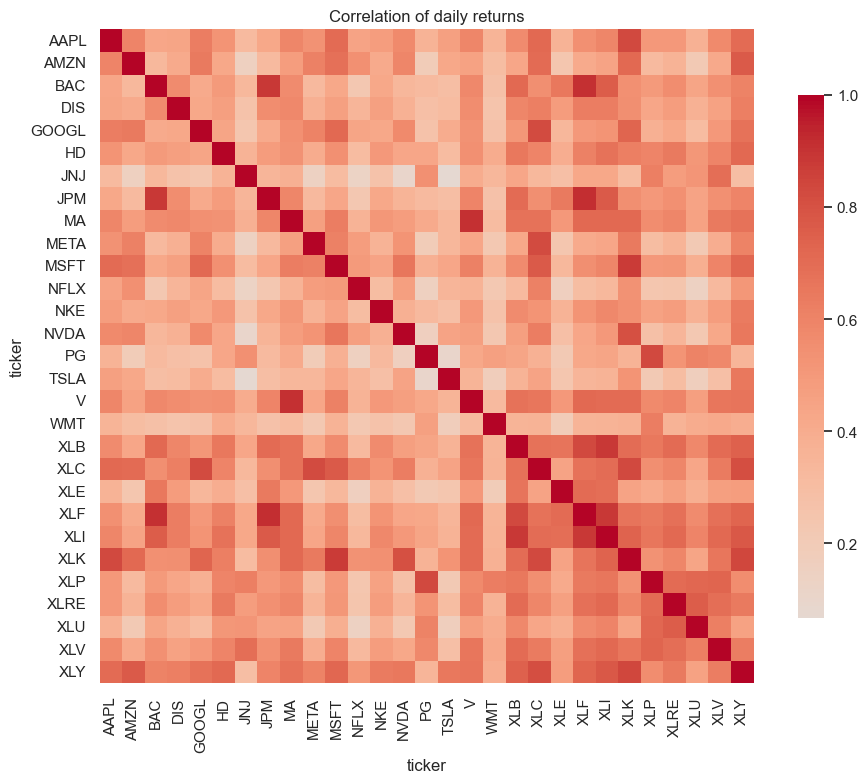

In [122]:
corr = returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, cbar_kws={'shrink': 0.8})
plt.title('Correlation of daily returns')
plt.tight_layout()
plt.show()


## Volume snapshot

**Insights:** Highest average volumes (mega-cap tech/ETFs) offer best liquidity for frequent rebalancing; thinly traded names may incur higher impact costs.

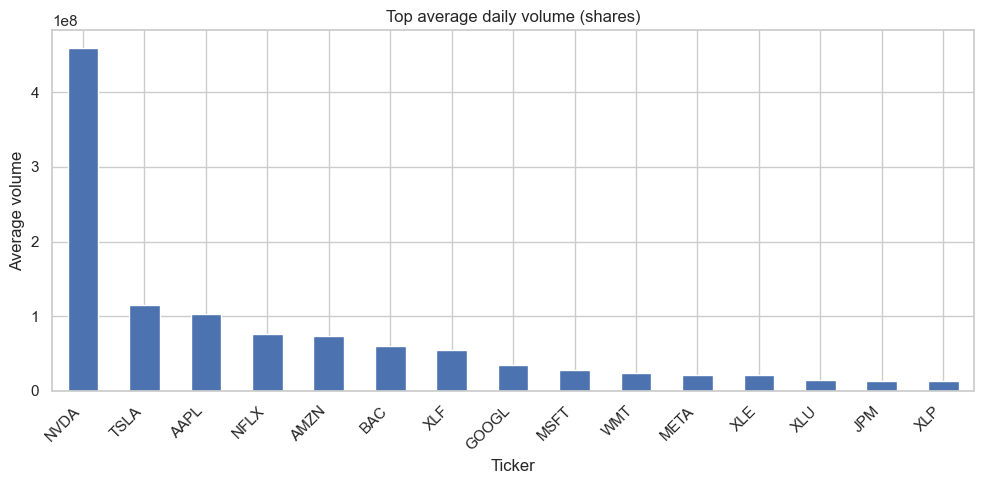

In [123]:
avg_vol = volume.mean().sort_values(ascending=False)
top_vol = avg_vol.head(15)

plt.figure(figsize=(10, 5))
top_vol.plot(kind='bar')
plt.title('Top average daily volume (shares)')
plt.ylabel('Average volume')
plt.xlabel('Ticker')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Quick insights

- Most tickers share a common 2015-11-27 start and extend through 2025-11-21 with minimal missing close data.
- Tech leaders (e.g., AAPL, MSFT, NVDA, AMZN) show strong price growth and elevated volatility; adjust `focus_tickers` to spotlight others.
- Return distributions are fat-tailed; expect large outliers?use log-returns for stability.
- Cross-asset correlations cluster by sector; diversification benefits vary?inspect the heatmap to pick complementary names.
- Volume rankings highlight liquidity; higher-volume names suit frequent rebalancing or intraday strategies.


# 📉 The Limitations of Static Analysis
So far, we have looked at **past performance** (trends, histograms) and **static relationships** (a single correlation heatmap).

However, to build a robust portfolio, we need to answer harder questions:
1. **Do correlations stay stable?** (If they break during a crash, our diversification fails).
2. **Is the "risk" we see real?** (Or is it just random noise?)
3. **How do we select the best combination?** (Picking stocks visually is impossible).

The following plots demonstrate why we need the **advanced statistical models** (Ledoit-Wolf, Mean-Variance Optimization) provided by our platform.

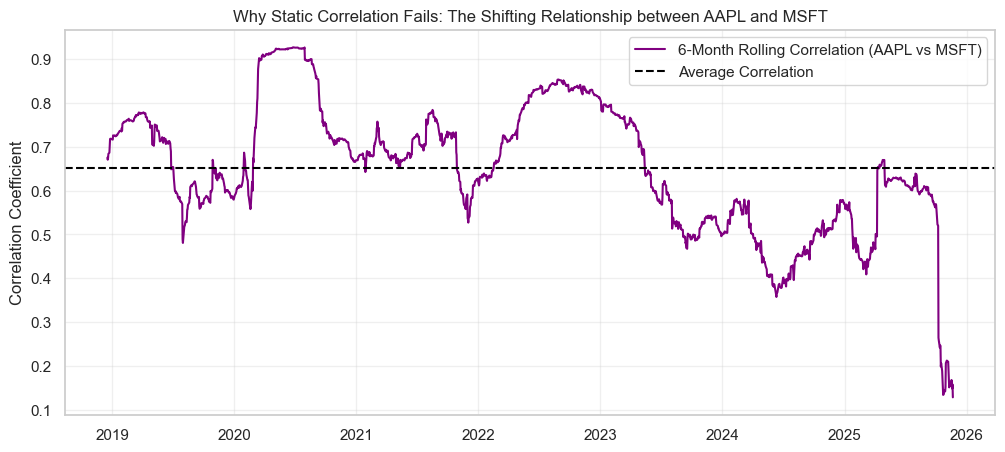

In [128]:
# Select two major assets to check relationship stability
# (We use the first two tickers in your focus list, e.g., AAPL and MSFT)
t1, t2 = focus_tickers[0], focus_tickers[1]

# Calculate a 6-month rolling correlation (approx 126 trading days)
rolling_corr = returns[t1].rolling(window=126).corr(returns[t2])

plt.figure(figsize=(12, 5))
plt.plot(rolling_corr, label=f'6-Month Rolling Correlation ({t1} vs {t2})', color='purple')
plt.axhline(rolling_corr.mean(), color='black', linestyle='--', label='Average Correlation')

plt.title(f'Why Static Correlation Fails: The Shifting Relationship between {t1} and {t2}')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 🚩 Problem 1: Correlations are Unstable
As seen above, the relationship between assets changes drastically over time. A static heatmap gives you a single number (the average), but in reality, correlations often **spike during market crashes**, eliminating the benefits of diversification exactly when you need them most.

**Our Solution:** The website uses **Ledoit-Wolf Shrinkage** to estimate a more robust covariance matrix that accounts for this noise.

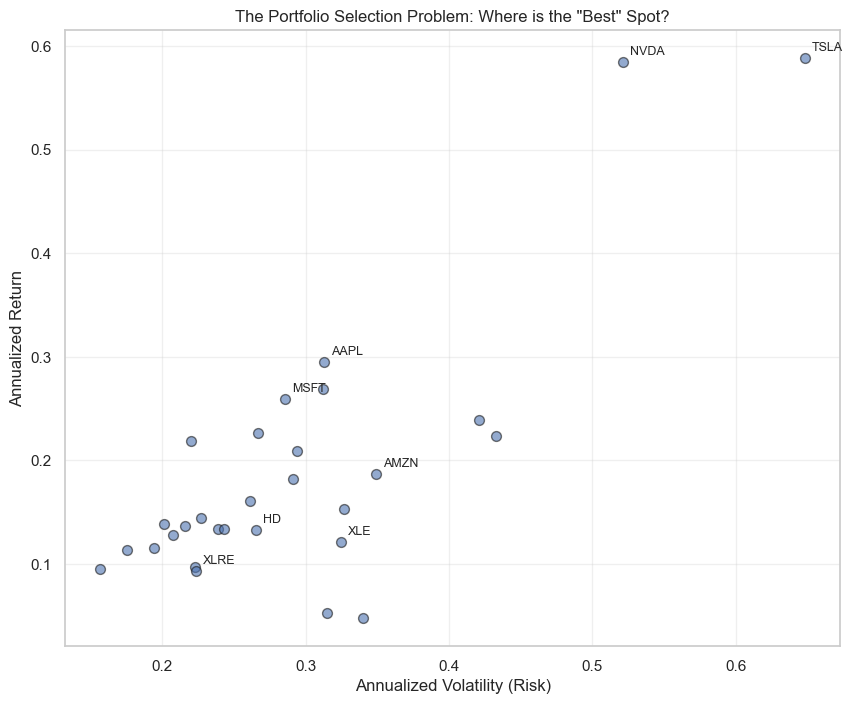

In [129]:
# Calculate annualized metrics for all tickers
annual_ret = returns.mean() * 252
annual_vol = returns.std() * np.sqrt(252)

plt.figure(figsize=(10, 8))
plt.scatter(annual_vol, annual_ret, alpha=0.6, s=50, edgecolors='k')

# Annotate a few key tickers so users can orient themselves
for i, ticker in enumerate(tickers):
    # Only label some tickers to avoid clutter (e.g., every 5th one or specific focus list)
    if ticker in focus_tickers or i % 5 == 0:
        plt.annotate(ticker, (annual_vol[ticker], annual_ret[ticker]), 
                     xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.title('The Portfolio Selection Problem: Where is the "Best" Spot?')
plt.xlabel('Annualized Volatility (Risk)')
plt.ylabel('Annualized Return')
plt.grid(True, alpha=0.3)
plt.show()

### 🚩 Problem 2: The "Cloud" of Confusion
Looking at the chart above, which stocks should you pick? 
* High return usually comes with high risk.
* Low risk usually means low return.
* Some stocks are just "bad" (high risk, low return).

Mathematically, there is an optimal "boundary" of portfolios that give the best return for a specific level of risk. You cannot find this boundary by looking at a chart.

**Our Solution:** This is where **Markowitz Mean-Variance Optimization** comes in. Our engine mathematically solves for the "Efficient Frontier," identifying the exact weights for a portfolio that outperforms any single stock in this cloud.

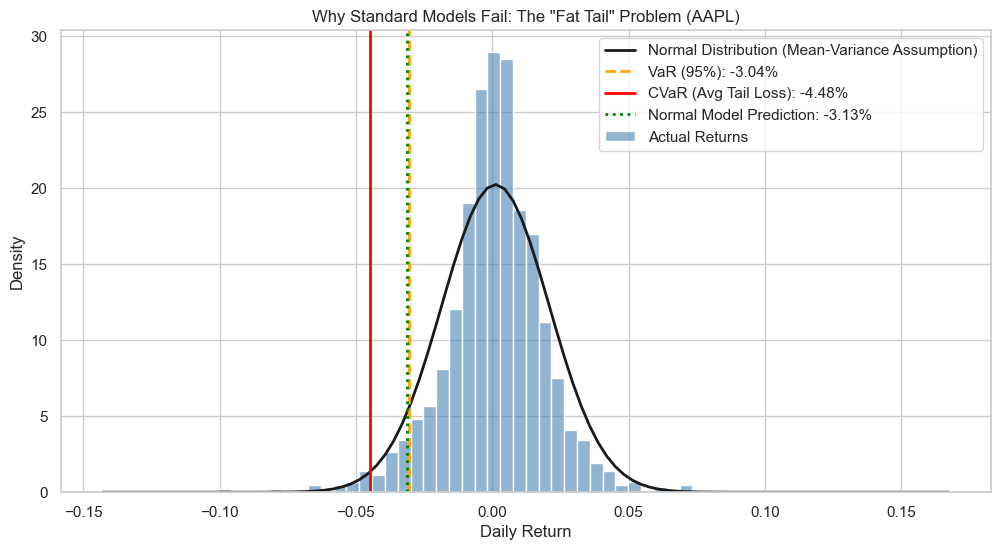

Normal Model Underestimates Risk by: 0.09%
Actual Average Loss in Worst 5% of days (CVaR): -4.48%


In [130]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Select a volatile ticker to demonstrate tail risk clearly
target_ticker = focus_tickers[0] # Usually AAPL, or change to 'NVDA'/'TSLA' if available
ret_data = returns[target_ticker].dropna()

# 1. Calculate Historical VaR and CVaR (95% Confidence)
confidence_level = 0.05
var_95 = ret_data.quantile(confidence_level)
cvar_95 = ret_data[ret_data <= var_95].mean()

# 2. Calculate what a "Normal" model predicts (Mean-Variance assumption)
mu, std = norm.fit(ret_data)
normal_var_95 = norm.ppf(confidence_level, mu, std)

# 3. Plot the reality vs. the assumption
plt.figure(figsize=(12, 6))
sns.histplot(ret_data, bins=60, stat='density', alpha=0.6, label='Actual Returns', color='steelblue')

# Plot the Normal Distribution Curve (The Assumption)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution (Mean-Variance Assumption)')

# Mark the Risk Metrics
plt.axvline(var_95, color='orange', linestyle='--', linewidth=2, label=f'VaR (95%): {var_95:.2%}')
plt.axvline(cvar_95, color='red', linestyle='-', linewidth=2, label=f'CVaR (Avg Tail Loss): {cvar_95:.2%}')
plt.axvline(normal_var_95, color='green', linestyle=':', linewidth=2, label=f'Normal Model Prediction: {normal_var_95:.2%}')

plt.title(f'Why Standard Models Fail: The "Fat Tail" Problem ({target_ticker})')
plt.xlabel('Daily Return')
plt.legend()
plt.show()

print(f"Normal Model Underestimates Risk by: {abs(var_95 - normal_var_95)*100:.2f}%")
print(f"Actual Average Loss in Worst 5% of days (CVaR): {cvar_95*100:.2f}%")

### 🚩 Problem 3: Ignoring the "Fat Tails" (Crash Risk)
The plot above reveals a critical flaw in standard investing:
* **The Green Line (Normal Assumption):** Standard **Mean-Variance Optimization** assumes risk follows a perfect bell curve. It predicts losses will rarely exceed the green line.
* **The Blue Bars (Reality):** Real market data has "Fat Tails." Crashes happen far more often than the model predicts.
* **The Red Line (CVaR):** This is the *actual* average loss during a crash. It is much deeper than the standard model expects.

**The Consequence:** A standard portfolio might look "safe" on paper (based on Standard Deviation) but will suffer catastrophic losses during a market downturn because it ignores these tail events.

**The Solution:** Our website offers **CVaR Optimization** (Conditional Value at Risk). Unlike Mean-Variance, this model specifically minimizes the *Red Line* (the expected loss in the worst-case scenarios), building a portfolio designed to survive market shocks.

# 🏁 Final Conclusion: Why Advanced Models Are Necessary

Our Exploratory Data Analysis (EDA) has revealed three critical characteristics of financial data that make simple "buy and hold" or manual stock picking dangerous:

1.  **Correlations are Unstable:** As shown in the *Rolling Correlation* plot, relationships between assets change over time. Diversification that works today might fail tomorrow if not mathematically stabilized.
2.  **Returns are Non-Normal:** The *Distributions* and *CVaR* analysis prove that "Fat Tail" events (market crashes) happen far more often than standard bell curves predict.
3.  **The Signal is Noisy:** The *Risk-Return Scatter* showed a chaotic cloud of options. Without filtering, it is impossible to distinguish between genuine patterns and random market noise.

### 🚀 How Our Platform Solves These Problems

Based on these findings, we can confirm that **visual analysis alone is insufficient** for building a robust portfolio. We need the statistical engines implemented in our web application to overcome these data flaws:

| Problem Identified in EDA | The Solution (Our Website) | How It Works |
| :--- | :--- | :--- |
| **Noisy Correlations** (False signals) | **Ledoit-Wolf Shrinkage** | Mathematically "shrinks" the covariance matrix to filter out random noise and estimation error. |
| **Selection Paralysis** (Which stock?) | **Markowitz Mean-Variance** | Solves for the "Efficient Frontier," identifying the exact mathematical weights that maximize return for a given risk. |
| **Fat Tail Crashes** (Hidden risk) | **CVaR Optimization** | Specifically minimizes *Conditional Value at Risk*, protecting the portfolio against the extreme losses we saw in the histogram tails. |

---

## Next steps

- Slice `focus_tickers` to explore specific sectors or portfolios.
- Swap `returns` for `log_returns` if you prefer log performance.
- Add factor/benchmark columns (e.g., market index) to compare beta or drawdowns.
- Downside Risk: It lacks a `Maximum Drawdown analysis`. Investors care deeply about "how much could I lose from the peak?", which volatility alone doesn't fully capture.